# UFC Analysis

1.	Run all imports at the top of the notebook
2.	I highly recommend not running the first 7 cells since they are complex and involve scraping that can take hours. When I ran them, I saved all the data into a pickle which is accessed on cell 8 where it says ‘START HERE’. Download ufc_master.pickle and start at cell 8. However, if you do want to run the previous cells, here is how:
   	a.	Run second cell to read in ufc_master data (you may have to change the path):
        i.	Download dataset here: https://www.kaggle.com/mdabbert/ultimate-ufc-dataset
    b.	DO NOT RUN SCRAPING CELL!
        i.	It got my IP address banned from tapology.com
        ii.	It also requires you to set up selenium for automation, which requires downloading a web driver and is complex. 
        iii. I saved the scraped information in a pickle which is opened in the next cell (make sure to download pickle and make the path accessible)
    c.	Run second cell to read in supplementary data (you may have to change the path):
        i.	Download dataset here if needed: https://www.kaggle.com/calmdownkarm/ufcdataset
    d.	Run all subsequent cells
3.	Now you should be able to run all subsequent cells in the notebook.
    a.	If you run into a GraphViz error when plotting the decision trees, download the package form here (https://graphviz.org/download/) and it should work.


## Imports

In [2]:
import pandas as pd
import numpy as np
!pip install swifter
!pip install geopy
import geopy
from geopy.geocoders import GoogleV3
from geopy import distance
from geopy.geocoders import Nominatim
import swifter
!pip install selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pickle
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
!pip install graphviz
from IPython.display import Image, display
import graphviz 
from sklearn.tree import export_graphviz
!pip install xgboost
from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px

## Does 'home field advantage' exist in the UFC?

In [1]:
#read in data
#master data: https://www.kaggle.com/mdabbert/ultimate-ufc-dataset
ufc_master = pd.read_csv('ufc-master.csv')
ufc_master.head()

NameError: name 'pd' is not defined

In [ ]:
# Scrape tapology.com for information on where each fighter trains and lives, add to fighter_cities dictionary

fighter_cities = {}
'''
def scrape_current_city(fighter_name):
    if fighter_name not in fighter_cities:
        PATH = 'C:\Program Files (x86)\chromedriver.exe'
        driver = webdriver.Chrome(PATH)
        driver.get("https://www.tapology.com/search")
        search = driver.find_element_by_id('searchField')
        search.send_keys(fighter_name)
        search.send_keys(Keys.RETURN)
        try:
            results = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "searchResultsFighter"))
            )
            try:
                link = driver.find_element_by_partial_link_text(' ' + fighter_name.split()[-1])
                link.click()
                city = driver.find_element_by_xpath('//*[@id="stats"]/ul/li[12]/span')
                city_text = city.text
                driver.quit()
                fighter_cities[fighter_name] = city_text
            except:
                driver.get("https://www.tapology.com/search")
                search = driver.find_element_by_id('searchField')
                search.send_keys(fighter_name)
                search.send_keys(Keys.RETURN)
                link = driver.find_element_by_partial_link_text(fighter_name.split()[0] + ' ')
                link.click()
                city = driver.find_element_by_xpath('//*[@id="stats"]/ul/li[12]/span')
                city_text = city.text
                driver.quit()
                fighter_cities[fighter_name] = city_text
        except Exception as ex:
            print('ERROR:', fighter_name, ex)
            city_text = np.NaN
            fighter_cities[fighter_name] = city_text
        finally:
            driver.quit()
            
#dump fighter_cities into pickle

with open('filename.pickle', 'wb') as handle:
    pickle.dump(fighter_cities, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

After running the above scraping code for a few hours, I was banned from the website. Doing this again, I would reccomend adding some pauses between requests. I only scraped around 400 locations, so I used another incomplete dataset to obtain more locations.

In [ ]:
# load in secondary dataset with information on where fighters train: https://www.kaggle.com/calmdownkarm/ufcdataset
# Note: this dataset is smaller than the master dataset

ufc_locations = pd.read_csv('ufc_locations.csv')

# Create dictionary mapping each fighter to their location
ufc_locations_B = ufc_locations[['B_Name', 'B_Location']]
fighter_cities_B = dict(ufc_locations_B.to_dict('split')['data'])
ufc_locations_R = ufc_locations[['R_Name', 'R_Location']]
fighter_cities_R = dict(ufc_locations_R.to_dict('split')['data'])
fighter_cities_2 = {**fighter_cities_B, **fighter_cities_R}

# Combine this data and data scraped from tapology into one dictionary

with open('filename.pickle', 'rb') as handle:
    fighter_cities_1 = pickle.load(handle)

fighter_cities = {**fighter_cities_1, **fighter_cities_2}

In [ ]:
#add fighter cities to ufc_master

def get_current_city(fighter_name):
    if fighter_name in fighter_cities:
        return fighter_cities[fighter_name]
    else:
        return np.NaN
    
ufc_master['R_fighter_city'] = ufc_master['R_fighter'].apply(get_current_city)
ufc_master['B_fighter_city'] = ufc_master['B_fighter'].apply(get_current_city)

percent_loc_missing = (ufc_master['R_fighter_city'].isna().sum() + ufc_master['B_fighter_city'].isna().sum())/(len(ufc_master.columns) * 2)
print(f'We are missing {percent_loc_missing}% of fighter locations')

In [ ]:
#calculate distance each fighter traveled to the fight
def travel_distance(fight_location, fighter_city):
    geolocator = Nominatim(user_agent="my_request")
    travel_distance.i += 1
    print('processing', travel_distance.i, 'of', len(ufc_master))
    try:
        _, fight = geolocator.geocode(fight_location)
        _, home = geolocator.geocode(fighter_city)
        d = distance.distance(fight, home).miles
        return d
    except Exception as ex:
        print('error', ex)
        return np.NaN
travel_distance.i = 0   
ufc_master['B_fighter_distance'] = ufc_master.apply(lambda x: travel_distance(x['location'], x['B_fighter_city']), axis=1)
ufc_master['R_fighter_distance'] = ufc_master.apply(lambda x: travel_distance(x['location'], x['R_fighter_city']), axis=1)

In [ ]:
#get consistent country name for each fighter and fight
def get_country(location_):
    geolocator = Nominatim(user_agent="my_request")
    get_country.i += 1
    print('processing', get_country.i, 'of', len(ufc_master))
    try:
        _, loc = geolocator.geocode(location_)
        country = geolocator.reverse(loc).raw['address']['country']
        return country
    except Exception as ex:
        print('error', ex)
        return np.NaN
get_country.i = 0  
ufc_master['R_fighter_country'] = ufc_master['R_fighter_city'].apply(lambda x: get_country(x))
get_country.i = 0  
ufc_master['B_fighter_country'] = ufc_master['B_fighter_city'].apply(lambda x: get_country(x))
get_country.i = 0  
ufc_master['fight_country'] = ufc_master['country'].apply(lambda x: get_country(x))

In [ ]:
#dump ufc_master into pickle
with open('ufc_master.pickle', 'wb') as handle:
    pickle.dump(ufc_master, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [86]:
### START HERE !!!!!
with open('ufc_master.pickle', 'rb') as handle:
    ufc_master = pickle.load(handle)

In [4]:
#create variable for winner for each corner
def r_won(winner):
    if winner == 'Blue':
        return 0 
    return 1
ufc_master['R_won'] = ufc_master['Winner'].apply(lambda x: r_won(x))
def b_won(winner):
    if winner == 'Red':
        return 0 
    return 1
ufc_master['B_won'] = ufc_master['Winner'].apply(lambda x: b_won(x))

#correct stance misspellings (some 'Switch' fighters are entered as 'Switch ')
def correct_stance(stance):
    if stance == 'Switch ':
        return 'Switch'
    return stance
ufc_master['R_Stance'] = ufc_master['R_Stance'].apply(correct_stance)
ufc_master['B_Stance'] = ufc_master['B_Stance'].apply(correct_stance)

In [5]:
#create boolean variables for if fighters fought in their home country
def home_country(fight_country, fighter_country):
    if pd.isna(fight_country) or pd.isna(fighter_country):
        return np.NaN
    elif fight_country == fighter_country:
        return 1
    return 0
ufc_master['R_fight_in_home_country'] = ufc_master.apply(lambda x: home_country(x['R_fighter_country'], x['fight_country']), axis=1)
ufc_master['B_fight_in_home_country'] = ufc_master.apply(lambda x: home_country(x['B_fighter_country'], x['fight_country']), axis=1)
ufc_master.head()

R_fighter           B_fighter  R_odds  B_odds        R_ev  \
0   Curtis Blaydes       Derrick Lewis  -400.0   300.0   25.000000   
1    Ketlen Vieira     Yana Kunitskaya  -278.0   215.0   35.971223   
2     Charles Rosa      Darrick Minner  -190.0   150.0   52.631579   
3  Aleksei Oleinik       Chris Daukaus   140.0  -177.0  140.000000   
4       Phil Hawes  Nassourdine Imavov     NaN     NaN         NaN   

         B_ev       date                location country Winner  ...  \
0  300.000000  2/20/2021  Las Vegas, Nevada, USA     USA   Blue  ...   
1  215.000000  2/20/2021  Las Vegas, Nevada, USA     USA   Blue  ...   
2  150.000000  2/20/2021  Las Vegas, Nevada, USA     USA   Blue  ...   
3   56.497175  2/20/2021  Las Vegas, Nevada, USA     USA   Blue  ...   
4         NaN  2/20/2021  Las Vegas, Nevada, USA     USA    Red  ...   

                          B_fighter_city  fight_country B_fighter_distance  \
0           Houston, Texas United States  United States        1228.208814   
1  Albuquerque, New Mexico United States  United States         483.943828   
2                               Nebraska  United States         920.218192   
3             Philadelphia, Pennsylvania  United States        2177.735406   
4                                    NaN  United States        5846.093336   

   R_fighter_distance  R_fighter_country  B_fighter_country  \
0         1525.252027      United States      United States   
1         4463.457651             Brazil      United States   
2         2166.809338      United States      United States   
3         5846.093336                NaN      United States   
4                 NaN                NaN                NaN   

   R_fight_in_home_country  B_fight_in_home_country  R_won  B_won  
0                      1.0                      1.0      0      1  
1                      0.0                      1.0      0      1  
2                      1.0                      1.0      0      1  
3                      NaN                      1.0      0      1  
4                      NaN                      NaN      1      0  

[5 rows x 148 columns]

Now that we have the necessary features to analyze the effects of traveling for fighters, I want to refactor the data so that each row is split into two rows, one for each fighter in the fight. I duplicate each row, swap values for R and B fighters in the duplicate rows, and then rename the columns to generic names.

In [56]:
r_cols = ['R_fighter','R_current_lose_streak', 'R_current_win_streak', 'R_draw', 'R_avg_SIG_STR_landed', 'R_avg_SIG_STR_pct',
        'R_avg_SUB_ATT', 'R_avg_TD_landed', 'R_avg_TD_pct', 'R_longest_win_streak', 'R_losses', 'R_total_rounds_fought', 
        'R_total_title_bouts', 'R_win_by_Decision_Majority', 'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous', 
        'R_win_by_KO/TKO', 'R_win_by_Submission', 'R_win_by_TKO_Doctor_Stoppage', 'R_wins', 'R_Stance', 'R_Height_cms',
        'R_Reach_cms', 'R_Weight_lbs',  'R_age', 'R_match_weightclass_rank', 'R_kd_bout','R_sig_str_landed_bout',
        'R_sig_str_attempted_bout', 'R_sig_str_pct_bout', 'R_tot_str_landed_bout', 'R_tot_str_attempted_bout',
        'R_td_landed_bout', 'R_td_attempted_bout', 'R_td_pct_bout', 'R_sub_attempts_bout', 'R_pass_bout', 'R_rev_bout',
        'R_fighter_city', 'R_fighter_distance', 'R_fighter_country', 'R_fight_in_home_country','R_won']

b_cols = ['B_fighter', 'B_current_lose_streak', 'B_current_win_streak', 'B_draw', 'B_avg_SIG_STR_landed', 'B_avg_SIG_STR_pct',
          'B_avg_SUB_ATT', 'B_avg_TD_landed', 'B_avg_TD_pct', 'B_longest_win_streak', 'B_losses', 'B_total_rounds_fought',
          'B_total_title_bouts', 'B_win_by_Decision_Majority', 'B_win_by_Decision_Split', 'B_win_by_Decision_Unanimous',
          'B_win_by_KO/TKO', 'B_win_by_Submission', 'B_win_by_TKO_Doctor_Stoppage', 'B_wins', 'B_Stance', 'B_Height_cms',
          'B_Reach_cms', 'B_Weight_lbs', 'B_age', 'B_match_weightclass_rank', 'B_kd_bout', 'B_sig_str_landed_bout',
          'B_sig_str_attempted_bout', 'B_sig_str_pct_bout', 'B_tot_str_attempted_bout', 'B_tot_str_landed_bout',
          'B_td_landed_bout', 'B_td_attempted_bout', 'B_td_pct_bout', 'B_sub_attempts_bout', 'B_pass_bout', 'B_rev_bout',
          'B_fighter_city', 'B_fighter_distance', 'B_fighter_country', 'B_fight_in_home_country', 'B_won']
    

In [57]:
#duplicating each row
ufc_double = ufc_master.loc[ufc_master.index.repeat(2),:].reset_index()
#getting index of duplicated rows for later reference
idx_duplicate = ufc_double.duplicated(keep='first')
#replacing duplicate row information for R fighter with information for B fighter for relevant rows
for r, b in zip(r_cols, b_cols):
    r_ = ufc_double.loc[idx_duplicate, r]
    ufc_double.loc[idx_duplicate, r] = ufc_double.loc[idx_duplicate,b]
    ufc_double.loc[idx_duplicate, b] = r_
    generic_name = r.replace('R_', '', 1)
    ufc_double.rename(columns={r:generic_name}, inplace=True)
    ufc_double.rename(columns={b:'opponent_'+generic_name}, inplace=True)
#dropping unncessary columns
ufc_double.drop(columns = ["Winner", "R_Women's Flyweight_rank",
       "R_Women's Featherweight_rank", "R_Women's Strawweight_rank",
       "R_Women's Bantamweight_rank", 'R_Heavyweight_rank',
       'R_Light Heavyweight_rank', 'R_Middleweight_rank',
       'R_Welterweight_rank', 'R_Lightweight_rank',
       'R_Featherweight_rank', 'R_Bantamweight_rank', 'R_Flyweight_rank',
       'R_Pound-for-Pound_rank', "B_Women's Flyweight_rank",
       "B_Women's Featherweight_rank", "B_Women's Strawweight_rank",
       "B_Women's Bantamweight_rank", 'B_Heavyweight_rank',
       'B_Light Heavyweight_rank', 'B_Middleweight_rank',
       'B_Welterweight_rank', 'B_Lightweight_rank',
       'B_Featherweight_rank', 'B_Bantamweight_rank', 'B_Flyweight_rank',
       'B_Pound-for-Pound_rank', 'opponent_won'], axis=1, inplace=True)
#add corner column
from itertools import cycle
corners = cycle(['R', 'B'])
ufc_double.insert(1, 'corner', [next(corners) for corner in range(len(ufc_double))])
ufc_double.head()

index corner          fighter opponent_fighter  R_odds  B_odds       R_ev  \
0      0      R   Curtis Blaydes    Derrick Lewis  -400.0   300.0  25.000000   
1      0      B    Derrick Lewis   Curtis Blaydes  -400.0   300.0  25.000000   
2      1      R    Ketlen Vieira  Yana Kunitskaya  -278.0   215.0  35.971223   
3      1      B  Yana Kunitskaya    Ketlen Vieira  -278.0   215.0  35.971223   
4      2      R     Charles Rosa   Darrick Minner  -190.0   150.0  52.631579   

    B_ev       date                location  ...  \
0  300.0  2/20/2021  Las Vegas, Nevada, USA  ...   
1  300.0  2/20/2021  Las Vegas, Nevada, USA  ...   
2  215.0  2/20/2021  Las Vegas, Nevada, USA  ...   
3  215.0  2/20/2021  Las Vegas, Nevada, USA  ...   
4  150.0  2/20/2021  Las Vegas, Nevada, USA  ...   

                            fighter_city  \
0       Chicago, Illinois  United States   
1           Houston, Texas United States   
2                Manaus, Amazonas Brazil   
3  Albuquerque, New Mexico United States   
4   Coconut Creek, Florida United States   

                   opponent_fighter_city  fight_country  \
0           Houston, Texas United States  United States   
1       Chicago, Illinois  United States  United States   
2  Albuquerque, New Mexico United States  United States   
3                Manaus, Amazonas Brazil  United States   
4                               Nebraska  United States   

  opponent_fighter_distance  fighter_distance  fighter_country  \
0               1228.208814       1525.252027    United States   
1               1525.252027       1228.208814    United States   
2                483.943828       4463.457651           Brazil   
3               4463.457651        483.943828    United States   
4                920.218192       2166.809338    United States   

   opponent_fighter_country  fight_in_home_country  \
0             United States                    1.0   
1             United States                    1.0   
2             United States                    0.0   
3                    Brazil                    1.0   
4             United States                    1.0   

   opponent_fight_in_home_country  won  
0                             1.0    0  
1                             1.0    1  
2                             1.0    0  
3                             0.0    1  
4                             1.0    0  

[5 rows x 122 columns]

In [58]:
#descriptive statistics for home country
print(ufc_double.groupby('fight_in_home_country')['won'].describe())

                        count      mean       std  min  25%  50%  75%  max
fight_in_home_country                                                     
0.0                    3473.0  0.503311  0.500061  0.0  0.0  1.0  1.0  1.0
1.0                    4355.0  0.547876  0.497760  0.0  0.0  1.0  1.0  1.0


In [59]:
#calculating correlation between distance and win
distance = ufc_double['fighter_distance']
won = ufc_double['won']
correlation = distance.corr(won)
correlation

-0.08948773322298545

In [32]:
#t-test for fighting in home vs foreign country
winner_at_home = ufc_double[ufc_double['fight_in_home_country'] == True]['won']
winner_away = ufc_double[ufc_double['fight_in_home_country'] == False]['won']
ttest_home_country = ttest_ind(winner_at_home, winner_away)
ttest_home_country

Ttest_indResult(statistic=3.9273689599188932, pvalue=8.661792192867336e-05)

Text(0.5, 0, 'Distance Traveled To Fight(miles)')

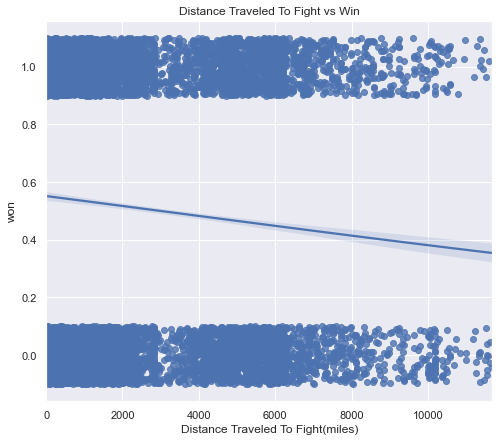

In [134]:
#plotting relationship between distance traveled from home city to fight and winning
sns.set()
fig, ax = plt.subplots(1, figsize=(8,7))
sns.regplot(x='fighter_distance', y='won', data=ufc_double, logistic = True, n_boot=500, y_jitter=0.1, ax=ax)
plt.title('Distance Traveled To Fight vs Win')
plt.xlabel('Distance Traveled To Fight(miles)')

## What makes fighters succesful?

First, we define a score for overall fighter success. We reward wins and penalize losses according to the ranking of the
fighter's opponent. We also award creater value to title fights and title defenses

In [60]:
def get_score(win, opponent_ranking, own_ranking):
    if win == 1:
        score = 1
        if not math.isnan(opponent_ranking):
            score += 1/(opponent_ranking + 1)
        if opponent_ranking == 0.0:
            score += 1
        if own_ranking == 0.0:
            score += 1
        return score
    else:
        score = -1
        if not math.isnan(opponent_ranking):
            score += 1/(opponent_ranking + 1)
            
        return score

ufc_double['score'] = ufc_double.apply(lambda x: get_score(x['won'], x['opponent_match_weightclass_rank'], x['match_weightclass_rank']), axis=1)
by_score = ufc_double.groupby('fighter')['score'].sum().sort_values(ascending = False)
by_score.head(15)

fighter
Jon Jones               26.342857
Demetrious Johnson      25.969444
Amanda Nunes            25.148485
Stipe Miocic            21.526923
Max Holloway            20.828968
Daniel Cormier          19.885714
Kamaru Usman            19.500000
TJ Dillashaw            18.361111
Khabib Nurmagomedov     18.183766
Joanna Jedrzejczyk      17.436111
Dustin Poirier          16.327056
Henry Cejudo            14.779004
Valentina Shevchenko    14.533333
Donald Cerrone          14.110628
Israel Adesanya         14.099802
Name: score, dtype: float64

Next, we group by fighter, getting summary statistics as anaggregate of all of their fights.

In [34]:
#dictionary of aggregation functions appropriate for each column that will be passed to the groupby
dict1 = {k:np.average for k in ufc_double.select_dtypes('number').columns}
dict1['score'] = np.sum
dict1['opponent_Stance'] = pd.Series.mode
dict1['Stance'] = pd.Series.mode
#dict1['fighter_country'] = pd.Series.mode
dict1['gender'] = pd.Series.mode
dict1['title_bout'] = pd.Series.sum
dict1['weight_class'] = pd.Series.mode
dict1

#group by fighter
by_fighter = ufc_double.groupby('fighter').agg(dict1)
by_fighter.head()

index      R_odds      B_odds       R_ev        B_ev  \
fighter                                                                      
 Jun Yong Park   767.000000 -138.000000  105.000000  72.463768  105.000000   
Aalon Cruz       453.000000 -190.000000  165.000000  52.631579  165.000000   
Aaron Phillips  2196.333333 -236.666667  150.000000  76.804862  223.172043   
Aaron Riley     4093.666667 -106.666667   80.000000  99.803922  173.888889   
Aaron Rosa      4138.333333 -116.666667   96.666667  75.772947  166.358025   

                no_of_rounds  opponent_current_lose_streak  \
fighter                                                      
 Jun Yong Park           3.0                      2.000000   
Aalon Cruz               3.0                      0.000000   
Aaron Phillips           3.0                      0.666667   
Aaron Riley              3.0                      0.666667   
Aaron Rosa               3.0                      0.666667   

                opponent_current_win_streak  opponent_draw  \
fighter                                                      
 Jun Yong Park                     0.000000            0.0   
Aalon Cruz                         0.000000            0.0   
Aaron Phillips                     0.333333            0.0   
Aaron Riley                        0.333333            0.0   
Aaron Rosa                         0.333333            0.0   

                opponent_avg_SIG_STR_landed  ...  fighter_distance  \
fighter                                      ...                     
 Jun Yong Park                          NaN  ...       5630.334704   
Aalon Cruz                         0.000000  ...        710.831449   
Aaron Phillips                    11.726667  ...       3310.100780   
Aaron Riley                       17.166667  ...       5513.945682   
Aaron Rosa                              NaN  ...       7184.999243   

                fight_in_home_country  opponent_fight_in_home_country  \
fighter                                                                 
 Jun Yong Park                    NaN                        0.000000   
Aalon Cruz                   1.000000                        1.000000   
Aaron Phillips               0.666667                        0.666667   
Aaron Riley                       NaN                             NaN   
Aaron Rosa                        NaN                             NaN   

                     won  score  opponent_Stance    Stance  gender  \
fighter                                                              
 Jun Yong Park  1.000000    1.0         Orthodox  Orthodox    MALE   
Aalon Cruz      0.000000   -1.0           Switch    Switch    MALE   
Aaron Phillips  0.000000   -3.0         Orthodox  Southpaw    MALE   
Aaron Riley     0.333333   -1.0         Orthodox  Southpaw    MALE   
Aaron Rosa      0.333333   -1.0         Orthodox  Orthodox    MALE   

                title_bout       weight_class  
fighter                                        
 Jun Yong Park           0       Middleweight  
Aalon Cruz               0      Featherweight  
Aaron Phillips           0       Bantamweight  
Aaron Riley              0        Lightweight  
Aaron Rosa               0  Light Heavyweight  

[5 rows x 108 columns]

<AxesSubplot:xlabel='score', ylabel='Density'>

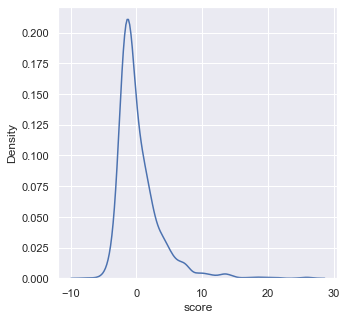

In [334]:
#Plotting distribution of fighter scores
sns.set()
sns.kdeplot(data=by_fighter, x='score')

In [335]:
#We examine the effect of stance on score
fig = px.box(by_fighter, x="Stance", y="score")
fig.show()

Text(0.5, 0, 'Total Strikes Attempted Per Round On Average')

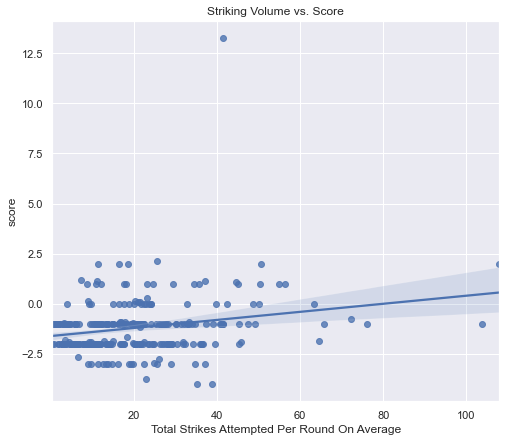

In [344]:
sns.set()
fig, ax = plt.subplots(1, figsize=(8,7))
sns.regplot(x= (by_fighter['tot_str_attempted_bout']/by_fighter['no_of_rounds']), y='score', data=by_fighter)
plt.title('Striking Volume vs. Score')
plt.xlabel('Total Strikes Attempted Per Round On Average')

<module 'matplotlib.pyplot' from 'C:\\Users\\Nathan\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

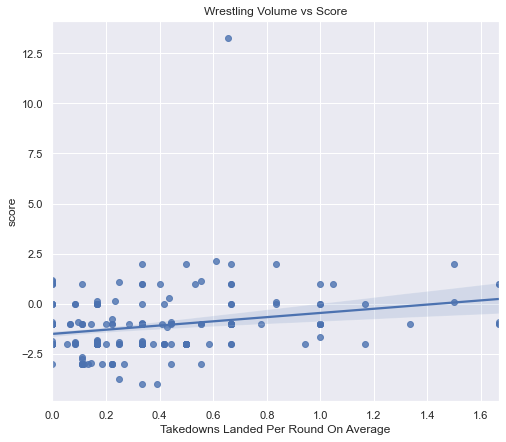

In [346]:
sns.set()
fig, ax = plt.subplots(1, figsize=(8,7))
sns.regplot(x= (by_fighter['td_landed_bout']/by_fighter['no_of_rounds']), y='score', data=by_fighter,  ax=ax)
plt.title('Wrestling Volume vs Score')
plt.xlabel('Takedowns Landed Per Round On Average')
plt

Plotting Time Series for Attack Volume

Text(0.5, 0, 'Year')

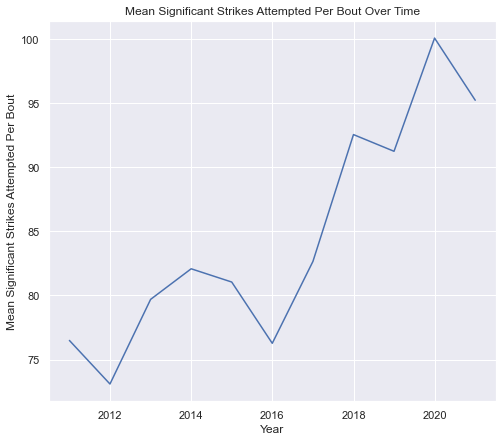

In [349]:
df = ufc_double
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index() 
yearly = df.resample('Y').mean()
sns.set()
fig, ax = plt.subplots(1, figsize=(8,7))
sns.lineplot(data=yearly, x="date", y="sig_str_attempted_bout")
plt.title('Mean Significant Strikes Attempted Per Bout Over Time')
plt.ylabel('Mean Significant Strikes Attempted Per Bout')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

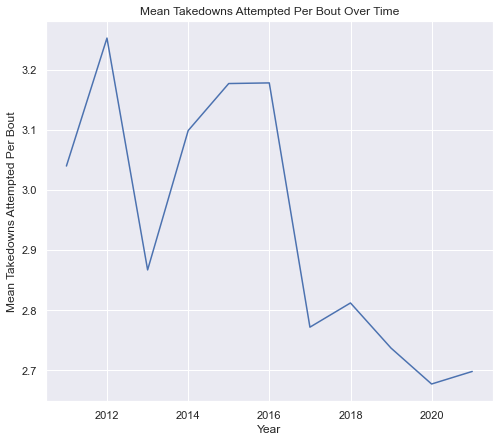

In [350]:
df = ufc_double
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index() 
yearly = df.resample('Y').mean()
sns.set()
fig, ax = plt.subplots(1, figsize=(8,7))
sns.lineplot(data=yearly, x="date", y="td_attempted_bout", ax = ax)
plt.title('Mean Takedowns Attempted Per Bout Over Time')
plt.ylabel('Mean Takedowns Attempted Per Bout')
plt.xlabel('Year')

## Predicting fight outcomes

In [61]:
#dump ufc_master into pickle
with open('ufc_double.pickle', 'wb') as handle:
    pickle.dump(ufc_double, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [77]:
with open('ufc_double.pickle', 'rb') as handle:
    ufc_double2 = pickle.load(handle)
ufc_double2.head()

index corner          fighter opponent_fighter  R_odds  B_odds       R_ev  \
0      0      R   Curtis Blaydes    Derrick Lewis  -400.0   300.0  25.000000   
1      0      B    Derrick Lewis   Curtis Blaydes  -400.0   300.0  25.000000   
2      1      R    Ketlen Vieira  Yana Kunitskaya  -278.0   215.0  35.971223   
3      1      B  Yana Kunitskaya    Ketlen Vieira  -278.0   215.0  35.971223   
4      2      R     Charles Rosa   Darrick Minner  -190.0   150.0  52.631579   

    B_ev       date                location  ...  \
0  300.0  2/20/2021  Las Vegas, Nevada, USA  ...   
1  300.0  2/20/2021  Las Vegas, Nevada, USA  ...   
2  215.0  2/20/2021  Las Vegas, Nevada, USA  ...   
3  215.0  2/20/2021  Las Vegas, Nevada, USA  ...   
4  150.0  2/20/2021  Las Vegas, Nevada, USA  ...   

                   opponent_fighter_city  fight_country  \
0           Houston, Texas United States  United States   
1       Chicago, Illinois  United States  United States   
2  Albuquerque, New Mexico United States  United States   
3                Manaus, Amazonas Brazil  United States   
4                               Nebraska  United States   

  opponent_fighter_distance fighter_distance  fighter_country  \
0               1228.208814      1525.252027    United States   
1               1525.252027      1228.208814    United States   
2                483.943828      4463.457651           Brazil   
3               4463.457651       483.943828    United States   
4                920.218192      2166.809338    United States   

   opponent_fighter_country  fight_in_home_country  \
0             United States                    1.0   
1             United States                    1.0   
2             United States                    0.0   
3                    Brazil                    1.0   
4             United States                    1.0   

   opponent_fight_in_home_country  won  score  
0                             1.0    0   -1.0  
1                             1.0    1    1.0  
2                             1.0    0   -1.0  
3                             0.0    1    1.0  
4                             1.0    0   -1.0  

[5 rows x 123 columns]

In [78]:
#drop unneeded columns
ufc_double2.drop(columns = ['finish', 'location', 'fighter', 'opponent_fighter', 'corner',
       'finish_details', 'finish_round', 'finish_round_time',
       'total_fight_time_secs', 'kd_bout', 'opponent_kd_bout',
       'sig_str_landed_bout', 'opponent_sig_str_landed_bout',
       'sig_str_attempted_bout', 'opponent_sig_str_attempted_bout',
       'sig_str_pct_bout', 'opponent_sig_str_pct_bout',
       'tot_str_landed_bout', 'opponent_tot_str_attempted_bout',
       'tot_str_attempted_bout', 'opponent_tot_str_landed_bout',
       'td_landed_bout', 'opponent_td_landed_bout', 'td_attempted_bout',
       'opponent_td_attempted_bout', 'td_pct_bout',
       'opponent_td_pct_bout', 'sub_attempts_bout',
       'opponent_sub_attempts_bout', 'pass_bout', 'opponent_pass_bout',
       'rev_bout', 'opponent_rev_bout', 'index', 'score', 'date', 'country','opponent_fighter_country', 'fighter_country', 'opponent_fighter_city', 'fighter_city', 'constant_1', 'fight_country'], inplace = True)

In [79]:
#drop empty rows
ufc_double_ = ufc_double2.dropna()
#split into features and labels, get dummy variables for categorical features
features = ufc_double_.loc[:,ufc_double_.columns != 'won']
features = pd.get_dummies(features)
print(features.columns.values)
labels = ufc_double_['won']
#split into testing and training sapmles
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.2, random_state = 123)

['R_odds' 'B_odds' 'R_ev' 'B_ev' 'title_bout' 'no_of_rounds'
 'opponent_current_lose_streak' 'opponent_current_win_streak'
 'opponent_draw' 'opponent_avg_SIG_STR_landed' 'opponent_avg_SIG_STR_pct'
 'opponent_avg_SUB_ATT' 'opponent_avg_TD_landed' 'opponent_avg_TD_pct'
 'opponent_longest_win_streak' 'opponent_losses'
 'opponent_total_rounds_fought' 'opponent_total_title_bouts'
 'opponent_win_by_Decision_Majority' 'opponent_win_by_Decision_Split'
 'opponent_win_by_Decision_Unanimous' 'opponent_win_by_KO/TKO'
 'opponent_win_by_Submission' 'opponent_win_by_TKO_Doctor_Stoppage'
 'opponent_wins' 'opponent_Height_cms' 'opponent_Reach_cms'
 'opponent_Weight_lbs' 'current_lose_streak' 'current_win_streak' 'draw'
 'avg_SIG_STR_landed' 'avg_SIG_STR_pct' 'avg_SUB_ATT' 'avg_TD_landed'
 'avg_TD_pct' 'longest_win_streak' 'losses' 'total_rounds_fought'
 'total_title_bouts' 'win_by_Decision_Majority' 'win_by_Decision_Split'
 'win_by_Decision_Unanimous' 'win_by_KO/TKO' 'win_by_Submission'
 'win_by_TKO_Do

Accuracy: 59.27%


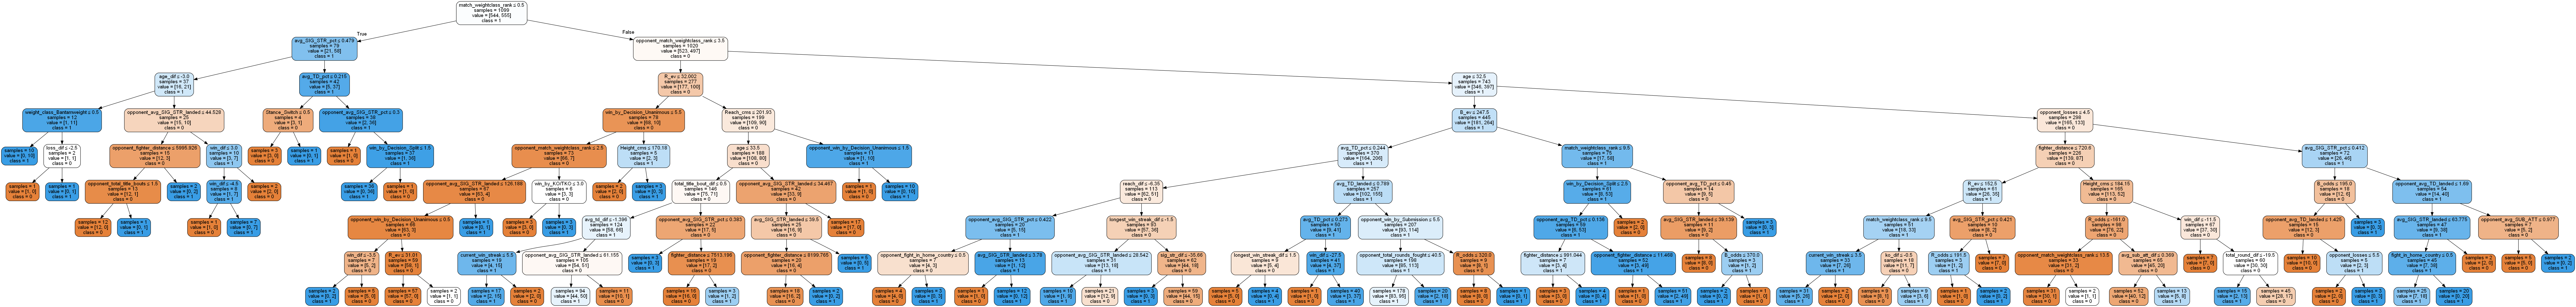

In [80]:
#Train DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 8)
#Fit and evaluate model
model.fit(features_train, labels_train)
y_pred = model.predict(features_test)
accuracy = accuracy_score(labels_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
def plot_tree(model, features, labels):
    dot_data = export_graphviz(model, out_file=None, 
        feature_names=features.columns,  
        class_names=[str(i) for i in labels_train.unique()],
        impurity=False,
        filled=True, rounded=True,  
        special_characters=True) 
    graphviz.Source(dot_data).render('tree.gv', format='png')
    display(Image(filename='tree.gv.png'))

plot_tree(model, features_train, labels_train)

In [82]:
#FIt and evaluate XG Boost Classifier
model  = XGBClassifier(colsample_bytree = 1, learning_rate = 0.4,
                max_depth = 4, alpha = 10, n_estimators = 10)
model.fit(features_train,labels_train)

y_pred = model.predict(features_test)
accuracy = accuracy_score(labels_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[02:59:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 64.73%


C:\Users\Nathan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


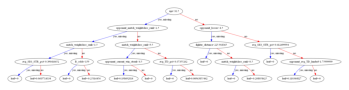

In [83]:
#plot XG Boost Classifier
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()


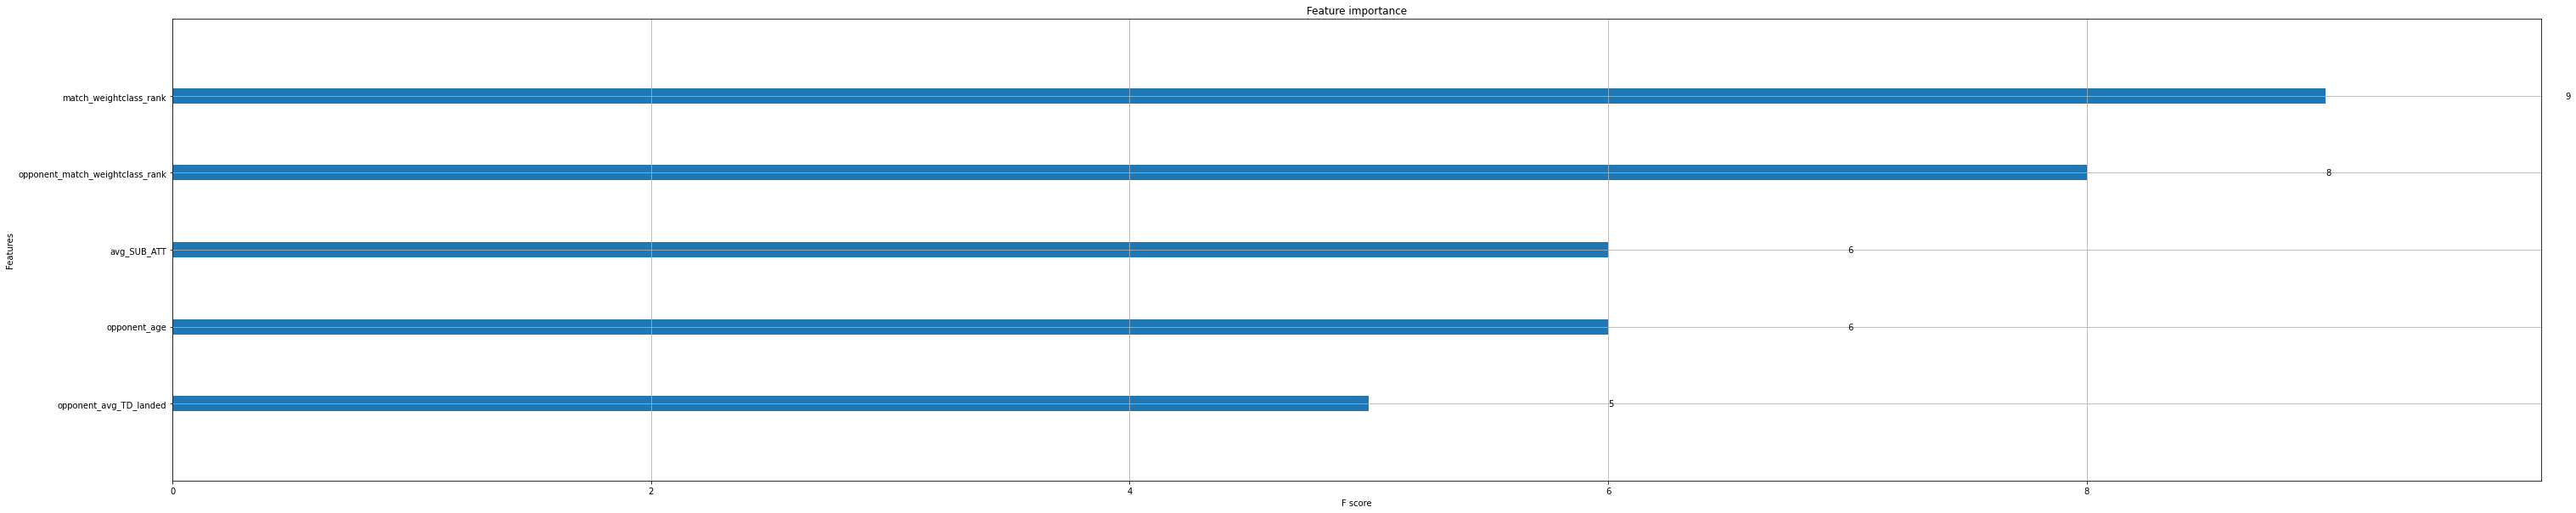

In [84]:
#Plot feature importance
xgb.plot_importance(model, max_num_features = 5)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [85]:
#Fit and evaluate Random Forest Classifier Model
RF_model = RandomForestClassifier(random_state=2, n_estimators = 350, max_depth = 7)
RF_model.fit(features_train, labels_train)
preds = RF_model.predict(features_test)
accuracy_score(labels_test, preds)

0.6145454545454545